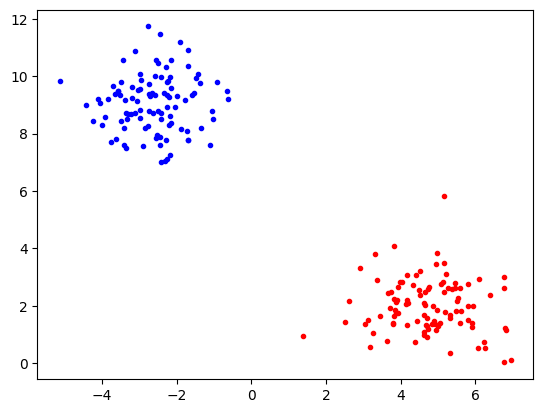

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(42)

X, y = make_blobs(n_samples=200, centers=2)
idxs_1 = np.argwhere(y==1)
idxs_0 = np.argwhere(y==0)
X1 = X[np.reshape(idxs_1, idxs_1.size)]
X0 = X[np.reshape(idxs_0, idxs_0.size)]

plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
y[y==0] -= 1

In [2]:
class SVM:
    """ 
    A regularized kernel SVM 
    
    ...

    Attributes
    ----------
    C : float
        The inverse regularization parameter
    kernel: str
        The kernel type (e.g. linear, gaussian_rbf, etc..)

    Methods
    -------
    train(X,y):
        Trains the model on the dataset (X,y)

    predict(q):
        Makes a prediction about query point q
    """
    def __init__(self, C, kernel="linear"):
        self.C = C
        self.kernel = kernel

    def _compute_w(self, X, y, alpha):
        """ Use representer theorem to retrieve w from alpha """
        N, D = X.shape

        w = np.zeros(D)
        for i in range(N):
            w += alpha[i]*y[i]*X[i]

        return w

    def _compute_b(self, y, alpha, K):
        N = K.shape[0]

        # Pick a point on the margin's boundary
        sv_idx = None
        for i in range(N):
            if alpha[i] > 0:
                sv_idx = i
        
        b = y[sv_idx]
        for i in range(N):
            b -= alpha[i]*y[i]*K[i,sv_idx]
            
        return b, sv_idx is not None
    
    def _float_equals(self, a, b, tol=1e-6):
        return abs(a - b) < tol

    def _has_converged(self, X, y, alpha, K, eps, j):
        """ Check if alpha values have converged """
        N, D = X.shape
        
        w = self._compute_w(X, y, alpha)
        b, found = self._compute_b(y, alpha, K)
        
        if not found:
            return False, w, b

        converged = True
        for i in range(N):
            if j == 199:
                print(alpha)
            if self._float_equals(alpha[i], 0):
                if not y[i]*(w@X[i] + b) >= 1 - eps:
                    converged = False
                    break
            elif self._float_equals(alpha[i], self.C):
                if not y[i]*(w@X[i] + b) <= 1 - eps:
                    converged = False
                    break
            else:
                if not self._float_equals((y[i]*(w@X[i] + b)).item(), 1, tol=eps):
                    converged = False
                    break
                
        return converged, w, b
    
    def train(self, X, y):
        """ Train the classifier using the SMO algorithm """
        N, D = X.shape

        # Picking feasible alpha
        alpha = np.zeros(N)
        eps = 0.01
        converged = False

        # Compute Kernel
        if self.kernel == "gaussian":
            K = self.compute_gaussian_kernel(X)
        else:
            K = self.compute_linear_kernel(X)

        i = 1 # use i (as idx of s) and i-1 (as idx of r) as alpha idxs
        while not converged:
            masked_alpha = np.copy(alpha)

            # Zero out alpha_r and alpha_s to vectorize
            masked_alpha[i-1] = 0
            masked_alpha[i] = 0
            zeta = -masked_alpha@y

            # Coefficient a of the quadratic expression in alpha_r
            a = -(1/2)*(y[i-1]**2*K[i-1,i-1]+y[i-1]**2*K[i,i]-2*y[i-1]**2*K[i-1,i])

            # Coefficient b of the quadratic expression in alpha_r
            sum = 0
            for j in range(N):
                if j == i or j == i-1:
                    continue

                sum += alpha[j]*y[j]*(K[i,j]-K[i-1,j])
                
            b = 1-(1/y[i])*y[i-1]+zeta*y[i-1]*(K[i,i]-K[i-1,i])+(1/2)*y[i-1]*sum
            
            proposed_alpha_r = -b/(2*a)
            proposed_alpha_s = (1/y[i])*(zeta - proposed_alpha_r)

            # Check if constraints are satisfied
            feasible = False
            masked_alpha[i-1] = proposed_alpha_r
            masked_alpha[i] = proposed_alpha_s
            
            constraint_a = self._float_equals(masked_alpha@y, 0)
            mask = np.logical_and(masked_alpha <= self.C, masked_alpha >= 0)
            constraint_b = np.sum(mask.astype(np.int8)) == N

            if y[i-1] == y[i]:
                if proposed_alpha_r <= min(self.C, y[i-1]*zeta):
                    if proposed_alpha_r >= max(0, -y[i-1]*(y[i]*self.C-zeta)):
                        feasible = constraint_a and constraint_b
            else:
                if proposed_alpha_r <= min(self.C, -y[i-1]*(y[i]*self.C-zeta)):
                    if proposed_alpha_r >= max(0, y[i-1]*zeta):
                        feasible = constraint_a and constraint_b

            if feasible:
                alpha[i-1] = proposed_alpha_r
                alpha[i] = proposed_alpha_s

            if not np.array_equal(alpha, np.zeros_like(alpha)):
                converged, w, b = self._has_converged(X, y, alpha, K, eps, i)

                if converged:
                    self.w = w
                    self.b = b
            
            i += 1
            if i >= N:
                print(np.linalg.norm(alpha))
                i = i % N

    def compute_gaussian_kernel(self, X, sigma=1.0):
        N, D = X.shape
        
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = np.exp(-(X[i]-X[j])@(X[i]-X[j])/(2*sigma**2))
                
        return K

    def compute_linear_kernel(self, X):
        return X@X.T

    def predict(self, q):
        return 1 if self.w@q + self.b >= 0 else -1

In [3]:
C = 1

svm = SVM(C, kernel="gaussian")
svm.train(X, y.astype('float64'))

[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.94044615e-01
 6.94044615e-01 7.34117526e-01 7.34117526e-01 6.21109338e-01
 6.21109338e-01 0.00000000e+00 9.52491267e-01 9.52491267e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70336595e-01 1.70336595e-01 3.99679353e-01
 3.99679353e-01 0.00000000e+00 2.13731515e-01 2.13731515e-01
 2.95582770e-01 2.95582770e-01 0.00000000e+00 1.88306766e-01
 1.88306766e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.88278647e-01 3.88278647e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.37646661e-01 2.37646661e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.07738471e-01 1.07738471e-01
 1.36977783e-01 1.369777

KeyboardInterrupt: 

In [ ]:
plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
svm.predict(np.array([-4, 6]))

prediction_grid = np.zeros((200, 200))

x = np.linspace(-6, 8, 200)
y = np.linspace(-1, 12, 200)

xv, yv = np.meshgrid(x, y, indexing='xy')
for i in range(200):
    for j in range(200):
        prediction_grid[i,j] = svm.predict(np.array([xv[j,i], yv[j,i]]))

plt.figure()
plt.imshow(prediction_grid)